# Programming Exercise 3: Perceptrons and Random Forest

## Grading

For this programming exercise, there are 45 points in total. Don't forget to hand in the pen and paper exercises as well.

**Required Exercises**

| Section | Part                                |Submitted Function                     | Points 
|---------|:-                                   |:-                                     | :-:    
| 1       | [Perceptrons](#section1)            | [`costFunction_hinge`](#costFunction_hinge)    |  10  
|         |                                     | [`predict_perceptron`](#predict_perceptron) |  10
| 2       | [Random Forest](#section_2)         | [`train_RF_combination`](#train_RF_combination) |  15     
|         |                                     | [`evaluate`](#evaluate) |  10
|         | Total Points                        |                                       | 45


In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# library written for this exercise providing additional functions
import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline
np.random.seed(123)  # this will ensure that we all get the same random numbers and we get consistent results

<a id="section1"></a>
### 1 Perceptrons

In this part, we will use most of the previous code with some small changes to train a perceptron classifier on the same data by using the hinge loss and compare its performace to the logistic regression model. As we have seen in the lectures, most of the parts such as data preparation and the optimization part remain almost the same. However, we need to change the cost function to hinge loss and also modify its gradients accordingly. We also need to change the predict functionality as the output of the two models have different interpretations. To put it in a slightly more technical terminology, the output of the logistic regression model is of a probabilstic nature and since we are dealing with binary classification, we need to use a threshold of 0.5. However, the output of the perceptron estimates the distance to the learnt decision boundary and therefore we only need to decide on which side of the decision boundry the point lies. But we are getting over our heads. Let's continue with coding. 

#### 1.1 Cost function and gradients

Now, complete the code for the function `costFunction_hinge` to return the cost and gradient. Recall that the cost function in (centered) hinge loss is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \max \left( -y^i . \theta^Tx^i, 0 \right)$$

Note that this is a definition using the $y \in \{-1,+1\}$ labeling notation. But our data in its original form is using a 0,1 labeling. Therefore, we either need to change the equation (see Problem 3 in Exercise Sheet /#2), or we have to adapt the input data to this form. Since the equation in this form is straightforward and makes the codes much easier to write and understand, we will choose to change the data accordingly.

In [2]:
# Load data
# The first two columns contains the exam scores and the third column
# contains the label.
data = np.loadtxt(os.path.join('Data', 'ex2data1.txt'), delimiter=',')
X, y = data[:, 0:2], data[:, 2]

In [3]:
# Setup the data matrix appropriately, and add ones for the intercept term
m, n = X.shape

# Add intercept term to X
X = np.concatenate([np.ones((m, 1)), X], axis=1)

In [4]:
# X remains the same
y_hinge = 2*(y-0.5)
# now, y_hinge only contains -1 or +1 values where the values for the former class 0 has changed to -1

check_index = 10
print('The {}-th example, with feature vector x^i={} was previously labeled as {}, but now is labeled as {}'.
     format(check_index, X[check_index], y[check_index], y_hinge[check_index]))

The 10-th example, with feature vector x^i=[ 1.         95.86155507 38.22527806] was previously labeled as 0.0, but now is labeled as -1.0


Moreover, it can be shown that while this cost function is convex, it is non-differentiable, therefore we need to use sub-gradients in the parameter update iterations. But for the sake of this assignment, as long as we have access to the gradients, it will not matter and we can proceed as usual. The gradient for the $j^{th}$ element (for $j = 0, 1, \cdots, n$) is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i \in L} -y^i{x^i}_j \hspace{1em} \text{for } \hspace{1em} L=\left\{ l \in [m]:  y^l\cdot \theta^Tx^l \leq 0 \right\} $$

In this case, we can easily write down the gradient vector instead of the partial derivatives:

$$ \nabla J(\theta) = \frac{1}{m} \sum_{i \in L} -y^i{x^i} \hspace{1em} \text{for } \hspace{1em} L=\left\{ l \in [m]:  y^l\cdot \theta^Tx^l \leq 0 \right\} $$

Basically, the gradient is the sum of some of the selected data points weighted by their labels.
<a id="costFunction_hinge"></a>

In [140]:
def costFunction_hinge(theta, X, y):
    m = y.size  # number of training examples

    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ====================== YOUR CODE HERE ======================
    
    print(theta.size, y.size)
    print(theta.T)
    prod= np.outer(y, theta.T)
    prod2=np.sum(np.maximum(X @ prod.T, 0))
    J= (1/m) * prod2
    grad= (1/m) * y @ X
    # =============================================================
    return J, grad

Lets run some checks:

In [141]:
initial_theta = np.random.randn(n+1)
print('Initiali theta was randomly initialized to: \t[{:.4f}, {:.4f}, {:.4f}]'.format(*initial_theta))

cost, grad = costFunction_hinge(initial_theta, X, y_hinge)
print('Cost at initial theta : {:.3f}'.format(cost))
print('Expected cost (approx): 26.506')
print('Gradient at initial theta:')
print('\t[{:.4f}, {:.4f}, {:.4f}]'.format(*grad))
print('Expected gradients (approx):\n\t[0.4, 20.81, 21.85]')

Initiali theta was randomly initialized to: 	[0.5539, -0.5307, 1.3773]
3 100
[ 0.55385617 -0.53067456  1.37725748]
Cost at initial theta : 3415.371
Expected cost (approx): 26.506
Gradient at initial theta:
	[0.2000, 24.0184, 22.5257]
Expected gradients (approx):
	[0.4, 20.81, 21.85]


#### 1.2 Evaluting the perceptron classifier
Now we will write `predict_perceptron` function that predicts the label based on the model's output. Here, we have the option to either predict 0,1 labels like the original format of the labels, or adapt to our new labeling changes and predict -1,+1 lables. Since the original data uses 0,1 labeling, we will also choose the same. However, we need to remember that for training our model, we use the modified labels `y_hinge` but for evaluation we have to use `y`.
<a id="predict_perceptron"></a>

In [97]:
def predict_perceptron(theta, X):
    """
    Predict whether the label is 0 or 1 using the perceptron model.
    Computes the predictions for X using the correct threshold. Remember that
    here, we are not dealing with a probability distribution estimation but 
    the model learns to predict a distance to the learnt decision boundary.
    
    Parameters
    ----------
    theta : array_like
        Parameters for the perceptron. A vecotor of shape (n+1, ).
    
    X : array_like
        The data to use for computing predictions. The rows is the number 
        of points to compute predictions, and columns is the number of
        features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X. 
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned 
    parameters.You should set p to a vector of 0's and 1's    
    """
    m = X.shape[0] # Number of training examples

    # You need to return the following variables correctly
    p = np.zeros(m)

    # ====================== YOUR CODE HERE ======================
    bias = theta[0]
    l= np.dot(X, theta)+bias
    p = np.where(l>0,1,0)
    
    # ============================================================
    return p

Now that we have everything ready, we just use the same optimization procedure using `scipy` to learn the parameters of the model. Later on, we will use `predict_perceptron` to evaluate the model on the training dataset and also compare it to logistic regression.

In [31]:
# set options for optimize.minimize
options= {'maxiter': 400}

# see documention for scipy's optimize.minimize  for description about
# the different parameters
# The function returns an object `OptimizeResult`
# We use truncated Newton algorithm for optimization which is 
# equivalent to MATLAB's fminunc
# See https://stackoverflow.com/questions/18801002/fminunc-alternate-in-numpy
res_hinge = optimize.minimize(costFunction_hinge,
                        initial_theta,
                        (X, y_hinge),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of `OptimizeResult` object returns
# the value of costFunction at optimized theta
cost_hinge = res_hinge.fun

# the optimized theta is in the x property
theta_hinge = res_hinge.x

# Print theta to screen
print('Cost at theta found by optimize.minimize: {:.3f}'.format(cost_hinge))
print('Expected cost (approx): 0.004')

print('theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*theta_hinge))
print('Expected theta (approx):\n\t[-1.105, 0.009, 0.009]')

Cost at theta found by optimize.minimize: -2546180131298024437246451620997976353153220608.000
Expected cost (approx): 0.004
theta:
	[-11588672651627049146341465045041237983232.000, -36441365516166215065320542139781407584550912.000, -74178137298202866896598333879747095126081536.000]
Expected theta (approx):
	[-1.105, 0.009, 0.009]


In [98]:
# Compute accuracy on our training set
p_hinge = predict_perceptron(theta_hinge, X)
print('Train Accuracy: {:.2f} %'.format(np.mean(p_hinge == y) * 100))
print('Expected accuracy (approx): 89.00 %')

Train Accuracy: 40.00 %
Expected accuracy (approx): 89.00 %


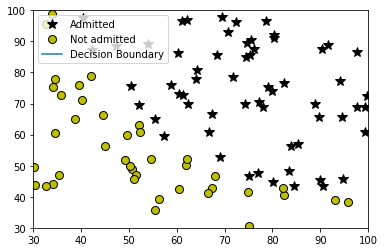

In [22]:
# Finally, let`s take a look at the hinge loss classifiers decision boundary
utils.plotDecisionBoundary(utils.plotData, theta_hinge, X, y)

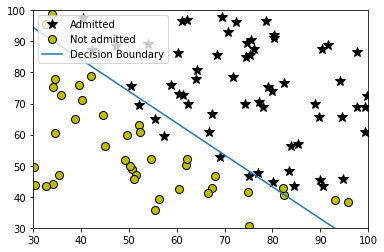

In [23]:
# and compare it to the one obtained from logistic regression
theta = [-25.161, 0.206, 0.201]  # obtained from exercise 2
utils.plotDecisionBoundary(utils.plotData, theta, X, y)

As you can see, using both methods led to the same accuracy (89%). However, if you look more carefully at both plots, you can see that there are slight differences in our solutions and the models we trained. But in general, you should know that choosing the right model and loss functions plays a crucial role. Different models, especially on more complicated datasets, could lead to different solutions to the task.

<a id="section_2"></a>
### 2 Random Forest

In practice you will often rely on already existing and optimized implementations for many algorithms. As discussed in the lecture the random forest is one of the best “off-the-shelf” classifiers we have.  To get used to using existing models you will use the sklearn random forest implementation [1]. The goal is to learn how to classify digits, for which we rely on an existing data set provided by sklearn [2]. Perform the following steps:

1. Prepare the data from load_digits as follows:

    - Split the data into train, validation and test set.
    - Validation and test set should each contain N=200 data points with the rest belonging to the training set.


2. Train the following combination of parameters on the train set and evaluate the learned model on the validation set.
    - Nr of trees in {5,10,20,100}
    - Split criterion in {Gini, Entropy}.
    - Depth of the individual trees in {2,5,10,pure}
        where pure refers to growing each tree until each leaf is pure.
    - use the random state "1234" for all calculations you do in numpy and sklearn.


3. Finally for all set of hyperparameters that perform best on the training set evaluate the performance on the test set.

You should provide your results together with your code in a .ipynb format for example by continuing in this notebook. You are not required to spend too much time on documenting your code and making it super readable. Just try to showcase your results, and make sure that the one can go through your experiments by running the notebook.

[1]: [ https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

[2]: [ https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)

In [218]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from itertools import product
np.random.seed(1234)

digits, labels = load_digits(return_X_y=True)

<a id="split_data"></a>

In [219]:
def split_data(digits, labels):
    """
    Split the data and the labels given according to the correct size.
    Use the function `train_test_split` as shown in the import.
    Make sure you use the random state "1234".
    
    Parameters
    ----------
    digits : array_like
        The digits of the whole dataset.
    
    labels : array_like
        The labels of the whole dataset.

    Returns
    -------
    (X_train, y_train, X_test, y_test, X_val, y_val) : array_like
        The corresponding splits of the 3 group.
    
    Instructions
    ------------
    Look at the following code and make sure you understand everything before moving on! 
    """
    # ====================== YOUR CODE HERE ======================

    X_train, X_rest, y_train, y_rest = train_test_split(digits, labels, test_size=400, random_state=1234)
    X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=200, random_state=1234)
    
    # ============================================================

    return X_train, y_train, X_test, y_test, X_val, y_val

In [176]:
X_train, y_train, X_test, y_test, X_val, y_val = split_data(digits, labels)

<a id="train_RF_combination"></a>

In [245]:
def train_RF_combination(n_trees, criterion, max_depth):
    """
    Train the random forest with number of trees in {5,10,20,100},
    split criterion in {Gini, Entropy} and depth in {2,5,10,pure}.
    CAUTION: Make sure you use the random state "1234".
    
    Parameters
    ----------
    n_trees : array_like
        list/array of number of trees to include in the grid search.
    
    criterion : array_like
        list/array of criterion to use.
        
    depth : array_like
        list/array of depth to iterate over.

    Returns
    -------
    best_param_list : array_like
        list/array of (n_tree, critera, max_depth) tuples that all reach the best validation accuracy possible.
        CAUTION: That might be more than one combination of the n_tree, critera and max_depth!
    
    Instructions
    ------------
    Complete the following code to return the best_param_list. 
    """
    best_val_acc = 0
    best_param_list = []  # list of tuples of (n_tree, critera, max_depth)!
    # ====================== YOUR CODE HERE ======================
    clf = RandomForestClassifier(n_estimators=n_trees,criterion=criterion,max_depth=max_depth, random_state=1234)
    clf.fit(X_train, y_train)
    score=clf.score(X_val, y_val)
    if score > best_val_acc:
        best_param_list.append(tuple([n_trees, criterion, max_depth, score]))
        best_val_acc = score


    
    # ============================================================
    return best_param_list

In [266]:
# call your implementation of train_RF_combination with the correct values here
# ====================== YOUR CODE HERE ======================
n_estimators=[5, 10, 20, 100]
criterion= ['gini', 'entropy']
max_depth=[2, 5, 10, None]
list1=list(product(n_estimators, criterion, max_depth))
listlis=[]
for i in list1:
    result=train_RF_combination(i[0],i[1],i[2])
    listlis.append(result)
lista=sorted(listlis, key=lambda x: x[0][3],reverse=True)
maxscore=lista[0][0][3]
best_param_list=[]
for item in lista:
    if item[0][3] == maxscore:
        best_param_list.extend(item)


# ============================================================

In [268]:
# Since we have already found the best hyperparameters, we should include the validation set to
# the training data for the final model
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

<a id="evaluate"></a>

In [269]:
def evaluate(X_train_val, y_train_val, X_test, y_test, best_param_list):
    """
    Evaluate the random forest model using all the combinations of n_tree, critera and max_depth you found 
    to perform the best.
    NOTE: Can be several combinations!
    Make sure you use the random state "1234".
    
    
    Parameters
    ----------
    X_train_val : array_like
        list/array of digits of the combined train and validation dataset.
    
    y_train_val : array_like
        list/array of labels of the combined train and validation dataset.
        
    X_test : array_like
        list/array of digits of the test dataset.
        
    y_test : array_like
        list/array of labels of the test dataset.
    
    best_param_list: array_like
        list of combinations of n_tree, critera and max_depth you found to perform best

    Returns
    -------
    test_acc_list : array_like
        list/array of the test accuracy for your trained models.
    
    Instructions
    ------------
    Complete the following code to return the test_acc_list. 
    """
    
    test_acc_list = []
    for best_param in best_param_list:
        # ====================== YOUR CODE HERE ======================
        clf = RandomForestClassifier(n_estimators=best_param[0],criterion=best_param[1],max_depth=best_param[2], random_state=1234)
        clf.fit(X_train_val, y_train_val)
        score=clf.score(X_test, y_test)
        test_acc_list.append(score)

        
        # ============================================================
        
    return test_acc_list

In [270]:
# call your implementation of evaluate with the correct values here
# ====================== YOUR CODE HERE ======================

test_acc_list = evaluate(X_train_val, y_train_val, X_test, y_test, best_param_list)  # modify me!

# ============================================================
print(test_acc_list)

[0.98, 0.995, 0.99, 0.995]


Optional!
Think about the following: Do you see any problem with this approach? If so, why?

In [ ]:
# the problem is overfitting since best scoring models have unlimited depth